# 时间序列

时间序列数据在很多领域都是重要的结构化数据形式，例如金融、经济、生态学、神经科学和物理学。在多个时间点观测或测量的数据形成了时间序列。许多时间序列是固定频率的，也就是说数据是根据相同的规则定期出现的，例如每15秒、每5分钟或每月1次。时间序列也可以是不规则的，没有固定的时间单位或单位间的偏移量。如何标记和引用时间序列数据取决于应用程序，并且可能有以下其中一项：
+ 时间戳，具体的时刻
+ 固定的时间区间，例如2007的1月或整个2010年。
+ 时间间隔，由于开始和结束时间戳表示。时间区间可以被认为是间隔的特殊情况。
+ 实验时间或消耗时间。每个时间戳是相对于特定开始时间的时间的量度（例如，自从被放置在烤箱中每秒烤箱的饼干的直径）。

在本章中，主要关注前三类的时间序列，尽管许多技术可以应用于实验时间序列，其中索引可以是整数，也可以是从实验开始时的消耗时间的浮点数。最简单和最广泛使用的时间序列是那些由时间戳索引的。

>pandas也支持基于时间间隔的索引，这是一种表示实验时间或消耗时间的有效方式。我们在本书中将不会探索时间间隔索引，但是可以在pandas官方文档 http://pandas.pydata.org 中学会更多。

## 日期和时间数据的类型及工具

Python标准库包含了日期和时间数据的类型，也包含日历相关的功能。datetime、time和calendar模块是开始处理时间数据的主要内容。datetime.datetime类型，或简写为datetime，是广泛使用的：

In [838]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [665]:
from datetime import datetime

In [666]:
now = datetime.now()
now.year, now.month, now.day

(2019, 5, 19)

datetime既存储了日期，也存储了细化到微妙时间。timedelta表示两个datetime对象的时间差：

In [667]:
delta = datetime(2011, 1, 7) - datetime(2008, 6, 24, 8, 15)
delta

datetime.timedelta(days=926, seconds=56700)

In [668]:
delta.days

926

In [669]:
delta.seconds

56700

可以为一个datetime对象加上（或减去）一个timedelta或其他整数倍产生一个新的datetime对象：

In [670]:
from datetime import timedelta

In [671]:
start = datetime(2011,1,7)
start + timedelta(12)#12天数

datetime.datetime(2011, 1, 19, 0, 0)

In [672]:
start - 2 * timedelta(12)

datetime.datetime(2010, 12, 14, 0, 0)

下表概括了datetime模块的数据类型。尽管本章主要关注的是pandas中的数据类型和高阶时间序列操作，但肯定会在其它地方遇到基于datetime的类型。

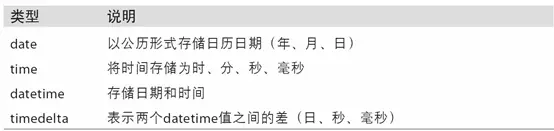

### 字符串于datetime互相转换

#### 可以使用str方法或传递一个指定的格式给strftime方法来对datetime对象和pandas的Timestamp对象进行格式化，这些将在稍后介绍：

In [673]:
stamp = datetime(2011,1,3)
str(stamp)

'2011-01-03 00:00:00'

In [674]:
stamp.strftime('%Y-%m-%d')

'2011-01-03'

下表是格式代码的完整列表：

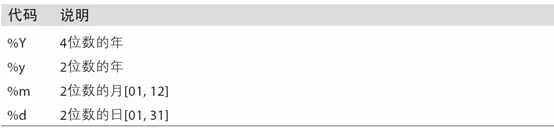

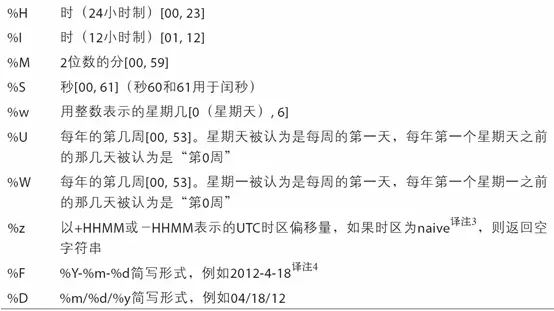

#### 可以使用datetime.strftime和这些格式代码，将字符串转换为日期：

In [675]:
value = '2011-01-03'
datetime.strptime(value, '%Y-%m-%d')

datetime.datetime(2011, 1, 3, 0, 0)

In [676]:
datestrs = ['7/6/2011', '8/6/2011']
[datetime.strptime(x, '%m/%d/%Y') for x in datestrs]

[datetime.datetime(2011, 7, 6, 0, 0), datetime.datetime(2011, 8, 6, 0, 0)]

#### 使用dateutil包的parser.parse方法也可以将字符串转化为datetime对象，并且更简单：
+ dateutil可以解析大部分人类可理解的日期表示

In [677]:
from dateutil.parser import parse

In [678]:
parse('2011-01-03')

datetime.datetime(2011, 1, 3, 0, 0)

In [679]:
parse('8/9/2011')

datetime.datetime(2011, 8, 9, 0, 0)

In [680]:
parse('Jan 31, 1997 10:45 PM')

datetime.datetime(1997, 1, 31, 22, 45)

在国际场合下，日期出现在月份之前，这是只需传递dayfirst=True:

In [681]:
parse('6/12/2011', dayfirst=True)

datetime.datetime(2011, 12, 6, 0, 0)

#### to_datetime方法可以转换很多不同的日期格式：

In [682]:
datestrs = ['2011-07-06 12:00:00','2011-08-06 00:00:00']
pd.to_datetime(datestrs)

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00'], dtype='datetime64[ns]', freq=None)

to_datetime方法同时还可以处理那些被认为是缺失值的值（None、空字符串等）：
+ NaT的意思是：not a time

In [683]:
idx = pd.to_datetime(datestrs + [None])
idx

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00', 'NaT'], dtype='datetime64[ns]', freq=None)

In [684]:
pd.isnull(idx)

array([False, False,  True])

>dateutil.parser是一个使用但是不完美的工具，比如说他会把原本不是日期的字符串人做事日期，例如：将“42”解析为2042的今天

datetime对象拥有许多其他国家或语言的本地化格式选项，参见下表：
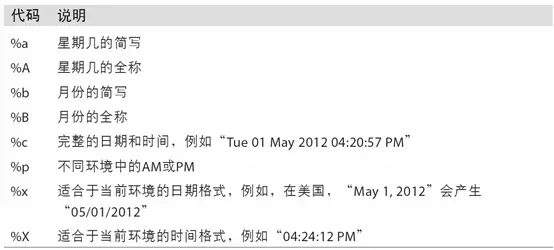

## 时间序列基础

pandas中的基础时间序列种类是由时间戳为索引的Series，索引通常表示为Python字符串或datetime对象：
+ pandas总是处理日期数组的，无论是轴索引还是列索引，在DataFrame中

In [685]:
from datetime import datetime

In [686]:
dates = [datetime(2011,1,2),datetime(2011,1,5),datetime(2011,1,7),
                 datetime(2011,1,8),datetime(2011,1,10),datetime(2011,1,12)]
ts = pd.Series(np.random.randn(6), index=dates)
ts

2011-01-02    0.848924
2011-01-05   -1.862165
2011-01-07   -1.183745
2011-01-08    0.095569
2011-01-10    0.336157
2011-01-12   -2.346382
dtype: float64

上述的datetime对象实际是放在DatetimeIndex中的：

In [687]:
ts.index

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

和其他Series雷西，不同索引的时间序列之间的算术在日期上自动对齐：

In [688]:
ts + ts[::2]

2011-01-02    1.697847
2011-01-05         NaN
2011-01-07   -2.367489
2011-01-08         NaN
2011-01-10    0.672314
2011-01-12         NaN
dtype: float64

pandas使用Numpy的datetime64数据类型在纳米级的分辨率下存储时间戳：

In [689]:
ts.index.dtype

dtype('<M8[ns]')

DatetimeIndex中的标量值是pandas的Timestamp对象：

In [690]:
stamp = ts.index[0]
stamp

Timestamp('2011-01-02 00:00:00')

>所有使用datetime对象的地方都可以使用Timestamp

### 索引、查询、选取子集

#### 普通索引

当基于标签进行索引和查询时，时间序列的操作和其他的pandas.Series类似：

In [691]:
ts

2011-01-02    0.848924
2011-01-05   -1.862165
2011-01-07   -1.183745
2011-01-08    0.095569
2011-01-10    0.336157
2011-01-12   -2.346382
dtype: float64

In [692]:
stamp = ts.index[2]
stamp

Timestamp('2011-01-07 00:00:00')

In [693]:
ts[stamp]

-1.183744668415896

还可以传递一个能解释为日期的字符串进行索引或查询：

In [694]:
ts['1/10/2011']

0.33615702156694116

In [695]:
ts['20110110']

0.33615702156694116

#### 切片

对一个长的时间序列，可以传递一个年份或者一个年份和月份，姐可以轻松地将数据进行切片：

In [696]:
longer_ts = pd.Series(np.random.randn(1000),
                      index=pd.date_range('1/1/2000', periods=1000))
longer_ts.head(10)

2000-01-01    0.301378
2000-01-02   -0.240782
2000-01-03   -0.639876
2000-01-04    0.254582
2000-01-05    0.960212
2000-01-06   -0.238029
2000-01-07    2.407085
2000-01-08    1.706727
2000-01-09    0.384510
2000-01-10   -0.711535
Freq: D, dtype: float64

In [697]:
longer_ts['2001']

2001-01-01    0.885558
2001-01-02    0.195232
2001-01-03    0.705676
2001-01-04   -0.847762
2001-01-05   -0.617054
2001-01-06   -0.709051
2001-01-07    0.677930
2001-01-08   -0.564085
2001-01-09   -0.636379
2001-01-10   -0.362220
2001-01-11    1.001219
2001-01-12   -0.447963
2001-01-13    1.082469
2001-01-14   -0.025260
2001-01-15   -1.029701
2001-01-16   -0.121167
2001-01-17   -1.116209
2001-01-18   -0.571509
2001-01-19   -1.860873
2001-01-20   -0.469882
2001-01-21    1.129556
2001-01-22    0.182737
2001-01-23   -1.078084
2001-01-24    0.678370
2001-01-25   -0.987100
2001-01-26   -0.073564
2001-01-27    1.162724
2001-01-28   -1.011753
2001-01-29    1.528234
2001-01-30    1.223293
                ...   
2001-12-02   -0.065629
2001-12-03   -1.081615
2001-12-04   -1.368375
2001-12-05   -0.082665
2001-12-06   -1.402733
2001-12-07    0.505576
2001-12-08    1.020621
2001-12-09    0.811911
2001-12-10   -0.486921
2001-12-11    0.260501
2001-12-12   -1.651593
2001-12-13    0.534234
2001-12-14 

In [698]:
longer_ts['2001-05']

2001-05-01   -0.556407
2001-05-02    1.482899
2001-05-03   -1.781230
2001-05-04    0.411362
2001-05-05   -0.367125
2001-05-06    1.699666
2001-05-07    0.388353
2001-05-08    0.708973
2001-05-09   -1.118896
2001-05-10    2.329981
2001-05-11   -0.594227
2001-05-12    0.877102
2001-05-13   -0.341581
2001-05-14    0.465817
2001-05-15   -1.452322
2001-05-16   -0.116992
2001-05-17    0.304650
2001-05-18    1.292881
2001-05-19   -2.039065
2001-05-20   -0.549783
2001-05-21    1.582080
2001-05-22    0.927996
2001-05-23    0.547625
2001-05-24   -0.300133
2001-05-25    1.165574
2001-05-26    0.773662
2001-05-27    1.370485
2001-05-28   -0.994407
2001-05-29   -1.248396
2001-05-30    0.242953
2001-05-31    0.180500
Freq: D, dtype: float64

使用datetime对象进行切片处理：

In [699]:
ts[datetime(2011,1,7):]

2011-01-07   -1.183745
2011-01-08    0.095569
2011-01-10    0.336157
2011-01-12   -2.346382
dtype: float64

因为大部分时间序列数据都是按时间序列排序的，所以可以使用`不包含在时间序列中的`时间戳进行切片，以执行范围查询：

In [700]:
ts['1/6/2011':'1/11/2011']

2011-01-07   -1.183745
2011-01-08    0.095569
2011-01-10    0.336157
dtype: float64

>以上的切片操作返回的都是与原时间序列的视图，若在切片上进行修改，修改会反映在原始数据上

truncate实例方法可以截取两个日期之间的TimeSeries：

In [701]:
ts.truncate(before='1/3/2011', after='1/9/2011')

2011-01-05   -1.862165
2011-01-07   -1.183745
2011-01-08    0.095569
dtype: float64

上述操作也都适用于DataFrame，例如，对DataFrame的行进行索引：

In [702]:
dates = pd.date_range('1/1/2000', periods=100,freq='W-WED')
dates

DatetimeIndex(['2000-01-05', '2000-01-12', '2000-01-19', '2000-01-26',
               '2000-02-02', '2000-02-09', '2000-02-16', '2000-02-23',
               '2000-03-01', '2000-03-08', '2000-03-15', '2000-03-22',
               '2000-03-29', '2000-04-05', '2000-04-12', '2000-04-19',
               '2000-04-26', '2000-05-03', '2000-05-10', '2000-05-17',
               '2000-05-24', '2000-05-31', '2000-06-07', '2000-06-14',
               '2000-06-21', '2000-06-28', '2000-07-05', '2000-07-12',
               '2000-07-19', '2000-07-26', '2000-08-02', '2000-08-09',
               '2000-08-16', '2000-08-23', '2000-08-30', '2000-09-06',
               '2000-09-13', '2000-09-20', '2000-09-27', '2000-10-04',
               '2000-10-11', '2000-10-18', '2000-10-25', '2000-11-01',
               '2000-11-08', '2000-11-15', '2000-11-22', '2000-11-29',
               '2000-12-06', '2000-12-13', '2000-12-20', '2000-12-27',
               '2001-01-03', '2001-01-10', '2001-01-17', '2001-01-24',
      

In [703]:
long_df = pd.DataFrame(np.random.randn(100, 4), index=dates, columns=['Colorado', 'Texas', 'New York', 'Ohio'])
long_df.loc['5-2001']

,Colorado,Texas,New York,Ohio
2001-05-02,0.367318,0.375937,0.368755,0.322951
2001-05-09,-0.674352,0.456366,-0.389196,-1.226158
2001-05-16,1.203422,-0.013359,-1.617236,-0.706178
2001-05-23,-1.256665,-0.317933,-0.875289,-0.532453
2001-05-30,-0.857062,-0.899391,0.509890,0.146617


### 含有重复索引的时间序列

在某些情况下，可能会出现多个观测值落在特定的时间戳上，例如：

In [704]:
dates = pd.DatetimeIndex(['1/1/2000', '1/2/2000', '1/2/2000', '1/2/2000', '1/3/2000'])
dup_ts = pd.Series(np.arange(5), index=dates)
dup_ts

2000-01-01    0
2000-01-02    1
2000-01-02    2
2000-01-02    3
2000-01-03    4
dtype: int32

可以通过索引的is_unique属性，查看索引十四否唯一：

In [705]:
dup_ts.index.is_unique

False

对上面的Series进行索引，其结果是Series切片还是标量值，取决于是否有重复的时间戳：

In [706]:
dup_ts['1/3/2000']

4

In [707]:
dup_ts['1/2/2000']

2000-01-02    1
2000-01-02    2
2000-01-02    3
dtype: int32

如果相聚和非唯一时间戳的数据，一种可行的办法是用groupby方法并传递level=0：

In [708]:
grouped = dup_ts.groupby(level=0)
grouped.mean()

2000-01-01    0
2000-01-02    2
2000-01-03    4
dtype: int32

In [709]:
grouped.count()

2000-01-01    1
2000-01-02    3
2000-01-03    1
dtype: int64

## 日期范围、频率和移动

pandas的通用时间序列是不规则的，即时间序列的频率从是不固定的。对于很多的应用来说，这就足够了。然而，经常有需要处理固定频率的场景，例如每日的、每月的、或每15分钟，这意味着需要在必要的时候向时间序列中引入缺失值。幸运的是，pandas有一整套标准的时间序列频率以及用于重采样、频率推断、生成固定频率日期范围的工具。例如，可以将之前那个时间序列转换为一个具有固定频率（每日）的时间序列，只需调用resample即可：

In [710]:
ts

2011-01-02    0.848924
2011-01-05   -1.862165
2011-01-07   -1.183745
2011-01-08    0.095569
2011-01-10    0.336157
2011-01-12   -2.346382
dtype: float64

In [711]:
resampler = ts.resample('D')
resampler

DatetimeIndexResampler [freq=<Day>, axis=0, closed=left, label=left, convention=start, base=0]

### 生成日期范围

pandas.date_range是用于根据特定频率生成指定长度的DatetimeIndex：

In [712]:
index = pd.date_range('2012-04-01','2012-06-01')
index

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20',
               '2012-04-21', '2012-04-22', '2012-04-23', '2012-04-24',
               '2012-04-25', '2012-04-26', '2012-04-27', '2012-04-28',
               '2012-04-29', '2012-04-30', '2012-05-01', '2012-05-02',
               '2012-05-03', '2012-05-04', '2012-05-05', '2012-05-06',
               '2012-05-07', '2012-05-08', '2012-05-09', '2012-05-10',
               '2012-05-11', '2012-05-12', '2012-05-13', '2012-05-14',
               '2012-05-15', '2012-05-16', '2012-05-17', '2012-05-18',
               '2012-05-19', '2012-05-20', '2012-05-21', '2012-05-22',
               '2012-05-23', '2012-05-24', '2012-05-25', '2012-05-26',
      

默认情况下，date_range生成的是每日的时间戳。还可以只传递起始或结尾的日期，但是另外要传入period参数：

In [713]:
pd.date_range(start='2012-04-01', periods=20)

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20'],
              dtype='datetime64[ns]', freq='D')

In [714]:
pd.date_range(end='2012-06-01', periods=20)

DatetimeIndex(['2012-05-13', '2012-05-14', '2012-05-15', '2012-05-16',
               '2012-05-17', '2012-05-18', '2012-05-19', '2012-05-20',
               '2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-26', '2012-05-27', '2012-05-28',
               '2012-05-29', '2012-05-30', '2012-05-31', '2012-06-01'],
              dtype='datetime64[ns]', freq='D')

开始日期和结束日期严格定义了生成日期索引的边界。例如，如果需要一个包含每月最后业务日期的时间索引，可以传递'BM'频率（business end of month，月度业务结尾），只有落在或在日期范围内的日期会被包含：

In [715]:
pd.date_range('2000-01-01', '2000-12-01', freq='BM')

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-28',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-29', '2000-10-31', '2000-11-30'],
              dtype='datetime64[ns]', freq='BM')

基础时间序列频率表：
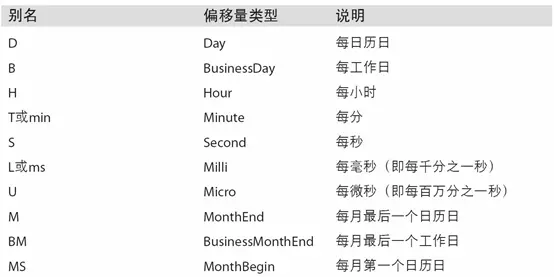

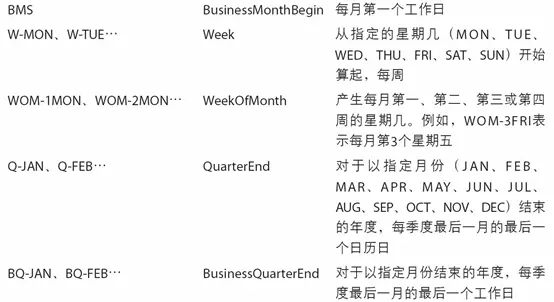

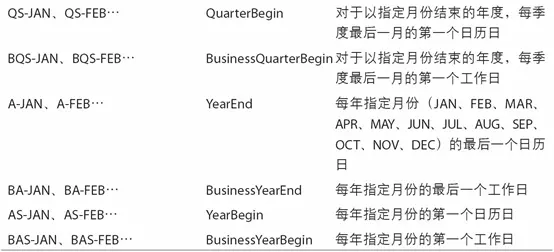

默认情况下，date_range会保留开始或结束时间戳的时间：

In [716]:
pd.date_range('2012-05-02 12:56:31', periods=5)

DatetimeIndex(['2012-05-02 12:56:31', '2012-05-03 12:56:31',
               '2012-05-04 12:56:31', '2012-05-05 12:56:31',
               '2012-05-06 12:56:31'],
              dtype='datetime64[ns]', freq='D')

如果想要将开始或结束时间戳的时间去除，可以将normalize设置为True实现这个功能：

In [717]:
pd.date_range('2012-05-02 12:56:31', periods=5, normalize=True)

DatetimeIndex(['2012-05-02', '2012-05-03', '2012-05-04', '2012-05-05',
               '2012-05-06'],
              dtype='datetime64[ns]', freq='D')

### 频率和日期偏移量

pandas中的频率是由基础频率和倍数组成的。基础频率通常会有字符串别名，例如：‘M’代表每月，‘H’代表每小时。对于每个基础频率，都有一个对象可以被用于定义日期偏移量。例如，每小时的频率可以使用Hour类来表示：

In [718]:
from pandas.tseries.offsets import Hour, Minute

In [719]:
hour = Hour()
hour

<Hour>

可以传递一个整数来定义偏移量的倍数：

In [720]:
four_hours = Hour(4)
four_hours

<4 * Hours>

但是在大多数情况下都不需要显示地创建这些对象，而是使用字符串别名，如‘H’或‘4H’。在基础频率前方一个整数可以生成倍数：

In [721]:
pd.date_range('2000-01-01', '2000-01-01 23:59', freq='4h')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 04:00:00',
               '2000-01-01 08:00:00', '2000-01-01 12:00:00',
               '2000-01-01 16:00:00', '2000-01-01 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

多个偏移量可以通过加法进行联合：

In [722]:
Hour(2) + Minute(30)

<150 * Minutes>

类似地，可以传递频率字符串，例如，‘1h30min’将会有效地转换为同等的表达式：

In [723]:
pd.date_range('2000-01-01',periods=10,freq='1h30min')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:30:00',
               '2000-01-01 03:00:00', '2000-01-01 04:30:00',
               '2000-01-01 06:00:00', '2000-01-01 07:30:00',
               '2000-01-01 09:00:00', '2000-01-01 10:30:00',
               '2000-01-01 12:00:00', '2000-01-01 13:30:00'],
              dtype='datetime64[ns]', freq='90T')

有些偏移量描述点的时间并不是均匀分隔的。例如之前的‘BM’，它取决于月末是否为周末。将这些日期称为锚定偏移量。
>用户还可以自己定义频率类型用于pandas中没有的日期类型，具体实现细节不做详述

#### 月中某星期的日期

“月中某星期”的日期是一个很有用的频率类，以‘WOM’开始，它可以获取每月第三个星期五这样的日期：

In [724]:
rng = pd.date_range('2012-01-01', '2012-09-01', freq='WOM-3FRI')
list(rng)

[Timestamp('2012-01-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-02-17 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-03-16 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-04-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-05-18 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-06-15 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-07-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-08-17 00:00:00', freq='WOM-3FRI')]

### 移动（向前和向后）日期

‘移动’是指将日期按时间向前或向后移动。Series和DateFrame都有一个shift方用于进行简单的前向或者后向移位，而不改变索引：

In [725]:
ts = pd.Series(np.random.randn(4),index=pd.date_range('1/1/2000',periods=4,freq='M'))
ts

2000-01-31    0.702788
2000-02-29    0.480135
2000-03-31    0.636873
2000-04-30   -0.171914
Freq: M, dtype: float64

In [726]:
ts.shift(2)

2000-01-31         NaN
2000-02-29         NaN
2000-03-31    0.702788
2000-04-30    0.480135
Freq: M, dtype: float64

In [727]:
ts.shift(-2)

2000-01-31    0.636873
2000-02-29   -0.171914
2000-03-31         NaN
2000-04-30         NaN
Freq: M, dtype: float64

当像上面这样进行移位时，会在时间的起始位或结束位引入缺失值。

shift常用于计算时间序列或DataFrame多列时间序列的百分比变化，代码实现如下：

ts / ts.shift(1) - 1

由于简单移位并不改变索引，一些数据会丢失。因此如果频率是已知的，则可以将频率传递给shift来推移时间戳而不是简单的数据：

In [728]:
ts.shift(2,freq='M')

2000-03-31    0.702788
2000-04-30    0.480135
2000-05-31    0.636873
2000-06-30   -0.171914
Freq: M, dtype: float64

其他的频率也可以传递，为前移和后移提供灵活性：

In [729]:
ts.shift(3, freq='D')

2000-02-03    0.702788
2000-03-03    0.480135
2000-04-03    0.636873
2000-05-03   -0.171914
dtype: float64

In [730]:
ts.shift(1,freq='90T')#T代表分钟

2000-01-31 01:30:00    0.702788
2000-02-29 01:30:00    0.480135
2000-03-31 01:30:00    0.636873
2000-04-30 01:30:00   -0.171914
Freq: M, dtype: float64

#### 使用偏移量进行移位日期

pandas日期偏移量也可以使用datetime或Timestamp对象完成：

In [731]:
from pandas.tseries.offsets import Day,MonthEnd

In [732]:
now = datetime(2011,11,17)
now + 3 * Day()

Timestamp('2011-11-20 00:00:00')

如果添加了一个锚定偏移量，比如MonthEnd，根据频率规则，第一个增量会将日期“前滚”到下一个日期：

In [733]:
now + MonthEnd()

Timestamp('2011-11-30 00:00:00')

In [734]:
now + MonthEnd(2)

Timestamp('2011-12-31 00:00:00')

锚定偏移量可以使用rollforward和rollback分别显示地将日期向前或向后“滚动”：

In [735]:
offset = MonthEnd()
offset.rollforward(now)

Timestamp('2011-11-30 00:00:00')

In [736]:
offset.rollback(now)

Timestamp('2011-10-31 00:00:00')

将移位与groupby一起使用是日期偏移量的一种创造性用法：

In [737]:
ts = pd.Series(np.random.randn(20),index=pd.date_range('1/15/2000',periods=20,freq='4d'))
ts

2000-01-15    0.231493
2000-01-19    1.650310
2000-01-23   -1.363230
2000-01-27    0.636631
2000-01-31    0.399947
2000-02-04   -0.849891
2000-02-08    1.428662
2000-02-12   -0.251154
2000-02-16    0.377984
2000-02-20    0.203052
2000-02-24   -1.475843
2000-02-28    0.135066
2000-03-03    0.200570
2000-03-07   -0.538687
2000-03-11    0.971233
2000-03-15   -1.092463
2000-03-19   -0.625974
2000-03-23    0.649443
2000-03-27    0.142486
2000-03-31    0.607994
Freq: 4D, dtype: float64

In [738]:
ts.groupby(offset.rollforward).mean()

2000-01-31    0.311030
2000-02-29   -0.061732
2000-03-31    0.039325
dtype: float64

另一种更快捷的方法：

In [739]:
ts.resample('M').mean()

2000-01-31    0.311030
2000-02-29   -0.061732
2000-03-31    0.039325
Freq: M, dtype: float64

## 时区处理

Python中，时区信息来源于第三方库pytz，它使Python可以使用Olson数据库（汇编了世界时区信息）。

如需关于pytz更多细节信息，可以查看该库的官方文档。本书中，pandas封装了pytz的功能，因此可以忽略pytz时区名称以外的API。

In [740]:
import pytz

In [741]:
pytz.common_timezones[-5:]

['US/Eastern', 'US/Hawaii', 'US/Mountain', 'US/Pacific', 'UTC']

可用pytz.timezone获取pytz的时区对象：

In [742]:
tz = pytz.timezone('America/New_York')
tz

<DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>

pandas中的方法可以接收时区名称或时区对象

### 时区的本地化和转换

默认情况下，pandas中的时间序列的时区信息是time zone naive。例如，下面的时间序列：

In [743]:
rng = pd.date_range('3/9/2012 9:30',periods=6,freq='D')
ts = pd.Series(np.random.randn(len(rng)),index=rng)
ts

2012-03-09 09:30:00   -0.182900
2012-03-10 09:30:00    0.293678
2012-03-11 09:30:00    0.184575
2012-03-12 09:30:00   -0.104450
2012-03-13 09:30:00   -1.040743
2012-03-14 09:30:00    0.704556
Freq: D, dtype: float64

tz的索引属性是None：

In [744]:
print(ts.index.tz)

None


日期范围可以由时区集合来生成：

In [745]:
pd.date_range('3/9/2012 9:30',periods=10, freq='D',tz='UTC')

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00', '2012-03-16 09:30:00+00:00',
               '2012-03-17 09:30:00+00:00', '2012-03-18 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

使用tz_localize方法可以从naive时区转换到本地化时区：
+ UTC是协调世界时

In [746]:
ts

2012-03-09 09:30:00   -0.182900
2012-03-10 09:30:00    0.293678
2012-03-11 09:30:00    0.184575
2012-03-12 09:30:00   -0.104450
2012-03-13 09:30:00   -1.040743
2012-03-14 09:30:00    0.704556
Freq: D, dtype: float64

In [747]:
ts_utc = ts.tz_localize('UTC')
ts_utc

2012-03-09 09:30:00+00:00   -0.182900
2012-03-10 09:30:00+00:00    0.293678
2012-03-11 09:30:00+00:00    0.184575
2012-03-12 09:30:00+00:00   -0.104450
2012-03-13 09:30:00+00:00   -1.040743
2012-03-14 09:30:00+00:00    0.704556
Freq: D, dtype: float64

In [748]:
ts_utc.index

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

可以将已经被本地化的某个特定时区转换为另一个时区：

In [749]:
ts_utc.tz_convert('America/New_York')

2012-03-09 04:30:00-05:00   -0.182900
2012-03-10 04:30:00-05:00    0.293678
2012-03-11 05:30:00-04:00    0.184575
2012-03-12 05:30:00-04:00   -0.104450
2012-03-13 05:30:00-04:00   -1.040743
2012-03-14 05:30:00-04:00    0.704556
Freq: D, dtype: float64

可先将naive时区本地化EST时区，然后再将EST时区转换为UTC时区或柏林时间：

In [750]:
ts_eastern = ts.tz_localize('America/New_York')
ts_eastern

2012-03-09 09:30:00-05:00   -0.182900
2012-03-10 09:30:00-05:00    0.293678
2012-03-11 09:30:00-04:00    0.184575
2012-03-12 09:30:00-04:00   -0.104450
2012-03-13 09:30:00-04:00   -1.040743
2012-03-14 09:30:00-04:00    0.704556
Freq: D, dtype: float64

In [751]:
ts_eastern.tz_convert('UTC')

2012-03-09 14:30:00+00:00   -0.182900
2012-03-10 14:30:00+00:00    0.293678
2012-03-11 13:30:00+00:00    0.184575
2012-03-12 13:30:00+00:00   -0.104450
2012-03-13 13:30:00+00:00   -1.040743
2012-03-14 13:30:00+00:00    0.704556
Freq: D, dtype: float64

In [752]:
ts_eastern.tz_convert('Europe/Berlin')

2012-03-09 15:30:00+01:00   -0.182900
2012-03-10 15:30:00+01:00    0.293678
2012-03-11 14:30:00+01:00    0.184575
2012-03-12 14:30:00+01:00   -0.104450
2012-03-13 14:30:00+01:00   -1.040743
2012-03-14 14:30:00+01:00    0.704556
Freq: D, dtype: float64

tz_localize和tz_convert也是DatetimeIndex的实例方法：

In [753]:
ts.index.tz_localize('Asia/Shanghai')

DatetimeIndex(['2012-03-09 09:30:00+08:00', '2012-03-10 09:30:00+08:00',
               '2012-03-11 09:30:00+08:00', '2012-03-12 09:30:00+08:00',
               '2012-03-13 09:30:00+08:00', '2012-03-14 09:30:00+08:00'],
              dtype='datetime64[ns, Asia/Shanghai]', freq='D')

>对单纯时间戳的本地化操作还会检查夏令时转变期附近容易混淆或不存在的时间。

### 时区感知时间戳对象的操作

与时间序列和日期范围类似，单独的Timestamp对象也可以本地化（从naive转换zone-aware），还可以从一个时区转换为另一个时区：

In [754]:
stamp = pd.Timestamp('2011-03-12 04:00')
stamp_utc = stamp.tz_localize('utc')
stamp_utc

Timestamp('2011-03-12 04:00:00+0000', tz='UTC')

In [755]:
stamp_utc.tz_convert('America/New_York')

Timestamp('2011-03-11 23:00:00-0500', tz='America/New_York')

在创建Timestamp的时候，同时可以传递一个时区：

In [756]:
stamp_moscow = pd.Timestamp('2011-03-12 04:00',tz='Europe/Moscow')
stamp_moscow

Timestamp('2011-03-12 04:00:00+0300', tz='Europe/Moscow')

zone-aware的Timestamp对象内部存储了一个纪元（1970年1月1日）至今的纳秒数量UTC时间戳数值，该数值在时区转换中是不变的：

In [757]:
stamp_utc.value

1299902400000000000

In [758]:
stamp_utc.tz_convert('America/New_York').value

1299902400000000000

在使用pandas中的DataOffset（日期偏置）进行时间计算时，pandas尽可能遵从夏时制（DST）。这里构建恰好在DST转换之前发生的时间戳（向前和向后）。构建转换到DST之前的30分钟的时间：

+ 🖐各国夏时令时间不同  
+ 美国的夏令时从三月的第二个周日开始到十一月的第一个周日结束。夏令时期间，时钟调快一个小时。以2012年为例，夏令时从3月11日-11月4日。时钟在3月11日凌晨02：00往前拨一个小时，到11月5日凌晨02：00再往回拨一个小时。
+ 英国的夏令时是从3月的最后一个星期天开始，到10月的最后一个星期天结束。以2017年来讲，是从3月26日开始，到10月29日结束。说了那么多，似乎很绕，但其实你只需要在3月最后一个星期六晚上把时钟拨快一个小时，在十月最后一个星期六晚上拨慢一个小时就OK了，那样上班、上学就不会迟到了。

In [759]:
from pandas.tseries.offsets import Hour

In [760]:
stamp = pd.Timestamp('2012-03-11 01:30', tz='US/Eastern')
stamp

Timestamp('2012-03-11 01:30:00-0500', tz='US/Eastern')

In [761]:
stamp + Hour()

Timestamp('2012-03-11 03:30:00-0400', tz='US/Eastern')

从DST（夏时令）转换前的90分钟的时间：

In [762]:
stamp = pd.Timestamp('2012-11-04 00:30',tz='US/Eastern')
stamp

Timestamp('2012-11-04 00:30:00-0400', tz='US/Eastern')

In [763]:
stamp + 2 * Hour()

Timestamp('2012-11-04 01:30:00-0500', tz='US/Eastern')

### 不同时区之间的操作

如果两个时区不同的时间序列需要联合，则结果一定是UTC时间，因为时间戳以UTC格式存储。这是一个简单的操作，不需要转换：

In [764]:
rng = pd.date_range('3/7/2012 9:30', periods=10, freq='B')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2012-03-07 09:30:00    0.575119
2012-03-08 09:30:00    1.952513
2012-03-09 09:30:00    0.617144
2012-03-12 09:30:00    1.435086
2012-03-13 09:30:00    0.584468
2012-03-14 09:30:00    0.849903
2012-03-15 09:30:00    0.681216
2012-03-16 09:30:00    0.838792
2012-03-19 09:30:00    0.247488
2012-03-20 09:30:00   -1.182829
Freq: B, dtype: float64

In [765]:
ts1 = ts[:7].tz_localize('Europe/London')
ts2 = ts1[2:].tz_convert('Europe/Moscow')
result = ts1 + ts2
result.index

DatetimeIndex(['2012-03-07 09:30:00+00:00', '2012-03-08 09:30:00+00:00',
               '2012-03-09 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='B')

## 周期和周期算术

周期表示的是时间范围，比如一些天、一些月、一些季度或者是一些年。Period类表示的正是这种数据类型，需要一个字符串或数字以及表中的频率：

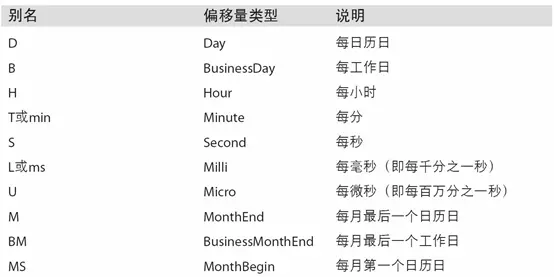

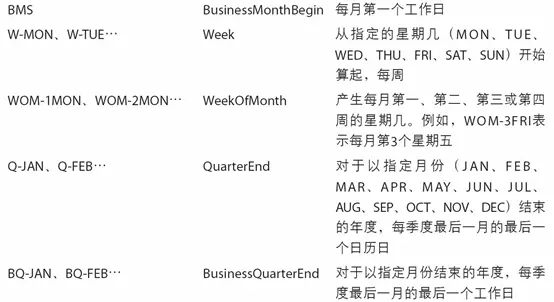

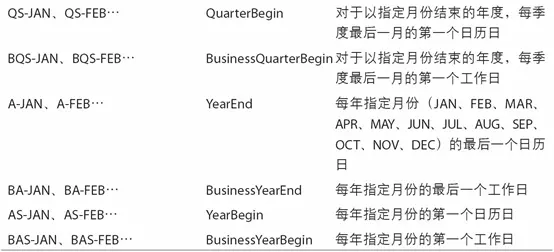

In [766]:
p = pd.Period(2007, freq='A-DEC')
p

Period('2007', 'A-DEC')

在这个例子中，Period对象表示的是从2007年1月1日到2007年12月31日（包含在内）的时间段。在时间段上增加或减去整数可以方便地根据它们的频率进行移位。

In [767]:
p + 5

Period('2012', 'A-DEC')

In [768]:
p - 2

Period('2005', 'A-DEC')

如果两个周期拥有相同的频率，则它们的差是它们之间的单位数：

In [769]:
pd.Period('2014',freq='A-DEC') - p

7

使用period_range函数可以构造规则的周期序列：

In [770]:
rng = pd.period_range('2000-01-01','2000-06-30',freq='M')
rng

PeriodIndex(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06'], dtype='period[M]', freq='M')

PeriodIndex类存储的是周期的序列，可以作为任意pandas数据结构的轴索引：

In [771]:
pd.Series(np.random.randn(6), index=rng)

2000-01    1.760364
2000-02   -0.698768
2000-03   -0.229508
2000-04   -0.730694
2000-05    2.280807
2000-06   -1.053650
Freq: M, dtype: float64

还可以对一组字符串数组使用PeriodIndex类：

In [772]:
values = ['2001Q3','2001Q2','2001Q1']
index = pd.PeriodIndex(values, freq='Q-DEC')
index

PeriodIndex(['2001Q3', '2001Q2', '2001Q1'], dtype='period[Q-DEC]', freq='Q-DEC')

### 周期频率转换

使用asfreq可以将区间和PerioIndex对象转换为其他的频率。例如，假设由一个年度周期，并且想在一年的开始或结束时将其转换为月度周期：

In [773]:
p = pd.Period('2007',freq='A-DEC')
p

Period('2007', 'A-DEC')

In [774]:
p.asfreq('M',how='start')

Period('2007-01', 'M')

In [775]:
p.asfreq('M',how='end')

Period('2007-12', 'M')

可以将Period('2007', freq='A-DEC')看作一段时间中的一种游标，将时间按月份划分，参见下图。对于一个不以12月为结束的财政年度，月度子时期的归属情况就不一样了：

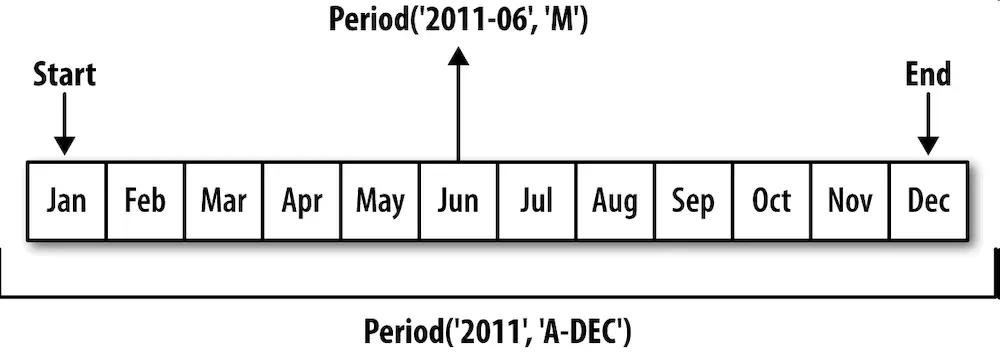

In [776]:
p = pd.Period('2007', freq='A-JUN')
p

Period('2007', 'A-JUN')

In [777]:
p.asfreq('M','start')

Period('2006-07', 'M')

In [778]:
p.asfreq('M','end')

Period('2007-06', 'M')

从高频率（周期小）向低频率（周期大）转换时，pandas根据子区间的“所属”来决定它的高级周期。例如，在A-JUN频率中，AUG-2007是2008周期的`一部分`：

In [779]:
p = pd.Period('AUG-2007','M')
p.asfreq('A-JUN')

Period('2008', 'A-JUN')

>诸如Period('2005','A-DEC')、Period('2006-07', 'M')只是代表一段时间，

完整的PeriodIndex对象或时间序列可以按照相同的 语义进行转换：

In [780]:
rng = pd.period_range('2006','2009',freq='A-DEC')
ts = pd.Series(np.random.randn(len(rng)),index=rng)
ts

2006    0.213192
2007    0.749439
2008    1.416144
2009   -0.525278
Freq: A-DEC, dtype: float64

In [781]:
ts.asfreq('M', how='start')

2006-01    0.213192
2007-01    0.749439
2008-01    1.416144
2009-01   -0.525278
Freq: M, dtype: float64

上述操作将年度周期替换为对应的每个年度周期的第一个月度周期。  
还可以将它转换为每年最后一个工作日：

In [782]:
ts.asfreq('B', how='end')#B表示工日的每一天

2006-12-29    0.213192
2007-12-31    0.749439
2008-12-31    1.416144
2009-12-31   -0.525278
Freq: B, dtype: float64

### 季度周期频率

季度数据是会计、金融和其他领域的标准。很多季度数据实在财年结尾报告，通常是一年12个月中的最后一个日历日或工作日。  
pandas支持多有可能的12个季度婆娘率从Q-JAN到Q-DEC：

In [783]:
p = pd.Period('2012Q4', freq='Q-JAN')
p

Period('2012Q4', 'Q-JAN')

在财年结束于1月的情况下，2012Q4运行时间为11月至1月，可以通过转换为每日频率进行检查：

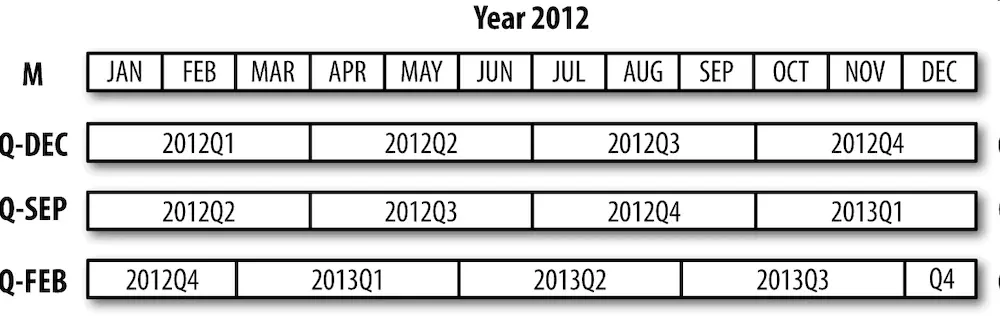

In [784]:
p.asfreq('D', 'start')

Period('2011-11-01', 'D')

In [785]:
p.asfreq('D', 'end')

Period('2012-01-31', 'D')

+ 简单的周期算术计算是可行的

例如，要获取在季度倒数第二个工作日下午4点的时间戳：

In [786]:
p4pm = (p.asfreq('B','end')-1).asfreq('T', 'start') + 16 * Hour()
p4pm

Period('2012-01-30 16:00', 'T')

转化为时间戳：

In [787]:
p4pm.to_timestamp()

Timestamp('2012-01-30 16:00:00')

再比如，对使用period_range生成的季度序列同样可以进行算术计算：

In [788]:
rng = pd.period_range('2011Q3','2012Q4', freq='Q-JAN')
ts = pd.Series(np.arange(len(rng)), index=rng)
ts

2011Q3    0
2011Q4    1
2012Q1    2
2012Q2    3
2012Q3    4
2012Q4    5
Freq: Q-JAN, dtype: int32

In [789]:
new_rng = (rng.asfreq('B', 'end')-1).asfreq('T', 'start') + 16 * Hour()
ts.index = new_rng.to_timestamp()
ts

2010-10-28 16:00:00    0
2011-01-28 16:00:00    1
2011-04-28 16:00:00    2
2011-07-28 16:00:00    3
2011-10-28 16:00:00    4
2012-01-30 16:00:00    5
dtype: int32

### 将时间戳转换为周期（以及逆转换）

使用to_period方法，可以将由时间戳索引的Series和DataFrame对象转换为以时期索引：

In [790]:
rng = pd.date_range('2000-01-01',periods=3, freq='M')
ts = pd.Series(np.random.randn(3), index=rng)
ts

2000-01-31    0.171512
2000-02-29   -1.035066
2000-03-31    0.521229
Freq: M, dtype: float64

In [791]:
pts = ts.to_period()
pts

2000-01    0.171512
2000-02   -1.035066
2000-03    0.521229
Freq: M, dtype: float64

由于时期指的是非重叠时间区间，因此对于给定的频率，一个时间戳只能属于一个时期。新PeriodIndex的频率默认是从时间戳推断而来的，你也可以指定任何别的频率。结果中允许存在重复时期：

In [792]:
rng = pd.date_range('1/29/2000', periods=6, freq='D')
ts2 = pd.Series(np.random.randn(6), index=rng)
ts2

2000-01-29    0.205291
2000-01-30   -0.995803
2000-01-31   -0.355505
2000-02-01   -0.018510
2000-02-02   -1.058736
2000-02-03    1.606344
Freq: D, dtype: float64

In [793]:
ts2.to_period('M')

2000-01    0.205291
2000-01   -0.995803
2000-01   -0.355505
2000-02   -0.018510
2000-02   -1.058736
2000-02    1.606344
Freq: M, dtype: float64

使用to_timestamp可以将周期在转换为时间戳：

In [794]:
pts = ts2.to_period()
pts

2000-01-29    0.205291
2000-01-30   -0.995803
2000-01-31   -0.355505
2000-02-01   -0.018510
2000-02-02   -1.058736
2000-02-03    1.606344
Freq: D, dtype: float64

In [795]:
pts.to_timestamp(how='e')

2000-01-29    0.205291
2000-01-30   -0.995803
2000-01-31   -0.355505
2000-02-01   -0.018510
2000-02-02   -1.058736
2000-02-03    1.606344
Freq: D, dtype: float64

### 从数组生成PeriodIndex

固定频率数据集有时存储在跨越多列的时间范围信息中。例如，在这个宏观经济数据集中，年份和季度在不同列中：

In [796]:
data = pd.read_csv('C:/Users/lenovo/data_of_python/examples/macrodata.csv')
data.head(5)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [797]:
data.year.head()

0    1959.0
1    1959.0
2    1959.0
3    1959.0
4    1960.0
Name: year, dtype: float64

In [798]:
data.quarter.head()

0    1.0
1    2.0
2    3.0
3    4.0
4    1.0
Name: quarter, dtype: float64

通过将这些数组和频率传递给PeriodIndex，可以联合这些数组形成DataFrame的索引：

In [799]:
index = pd.PeriodIndex(year=data.year, quarter=data.quarter, freq='Q-DEC')
index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', length=203, freq='Q-DEC')

>PeriodIndex()中的参数
>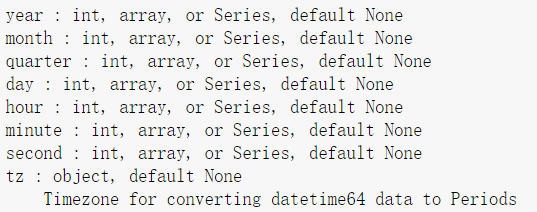

In [800]:
data.index = index

In [801]:
data.infl.head()

1959Q1    0.00
1959Q2    2.34
1959Q3    2.74
1959Q4    0.27
1960Q1    2.31
Freq: Q-DEC, Name: infl, dtype: float64

## 重新采样与频率转换

重采样（resampling）指的是将时间序列从一个频率转换到另一个频率的处理过程。将高频率数据聚合到低频率称为向下采样（downsampling），而将低频率数据转换到高频率则称为向上采样（upsampling）。并不是所有的重采样都能被划分到这两个大类中。例如，将W-WED（每周三）转换为W-FRI既不是降采样也不是升采样。

pandas对象都带有一个resample方法，它是各种频率转换工作的主力函数。resample有一个类似于groupby的API，调用resample可以分组数据，然后会调用一个聚合函数：

In [802]:
rng = pd.date_range('2000-01-01', periods=100, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts.head(10)

2000-01-01    1.548776
2000-01-02   -0.156669
2000-01-03    2.658526
2000-01-04    0.581402
2000-01-05    1.488245
2000-01-06   -0.907565
2000-01-07    1.660095
2000-01-08    0.636383
2000-01-09    0.528812
2000-01-10   -2.606477
Freq: D, dtype: float64

In [803]:
ts.resample('M').count()

2000-01-31    31
2000-02-29    29
2000-03-31    31
2000-04-30     9
Freq: M, dtype: int64

In [804]:
ts.resample('M', kind='period').count()

2000-01    31
2000-02    29
2000-03    31
2000-04     9
Freq: M, dtype: int64

resample是一个灵活且高性能的方法，可以用于处理大型时间序列，下一节的例子将会说明它的语义和用途。下表是resample方法的部分选项

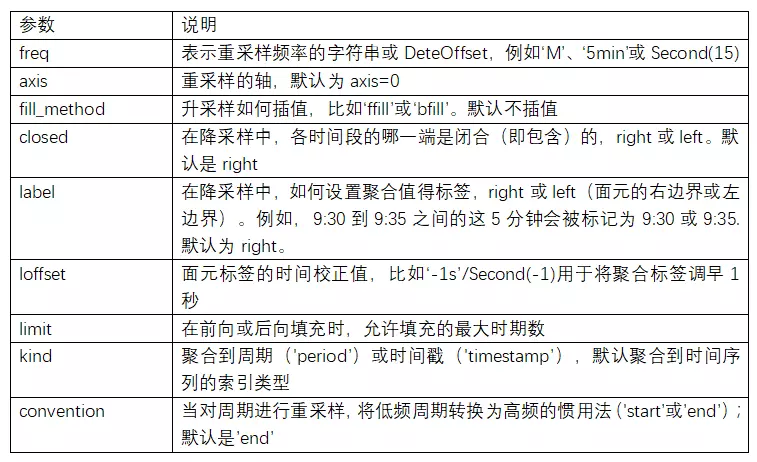

### 向下采样（从高频率到低频率）

将数据聚合到规律的低频率是一件非常普通的时间序列处理任务。待聚合的数据不必拥有固定的频率，期望的频率会自动定义用于对时间序列进行切片以聚合的箱体边界。例如，要转换到月度频率（'M'或'BM'），数据需要被划分到多个单月时间段中。各时间段都是半闭合的。一个数据点只能属于一个时间段，所有时间段的并集必须能组成整个时间帧。在用resample对数据进行降采样时，需要考虑两样东西：
+ 每段间隔的哪一边是闭合的
+ 如何再间隔的起始点和结束位置标记每个已聚合的箱体  

为了说明，看下面的例子：

In [805]:
rng = pd.date_range('2000-01-01', periods=12, freq='T')
ts = pd.Series(np.arange(12), index=rng)
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: T, dtype: int32

假设想通过计算每一组的加和以达到将这些数据聚合到五分钟的块或柱内：

In [806]:
ts.resample('5min').sum()

2000-01-01 00:00:00    10
2000-01-01 00:05:00    35
2000-01-01 00:10:00    21
Freq: 5T, dtype: int32

传递的频率按五分钟的增量定义了箱体边界。默认情况下，在箱体边界是包含的，因此00:00的值是包含在00:00到00:05间隔内的。传递closed='right'渐渐个的闭合端改为了右边：

In [807]:
ts.resample('5min', closed='right').sum()

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int32

产生的时间序列按照每个箱体左边的时间戳被标记。传递label='right'，可以使用右箱体边界标记时间序列：

In [808]:
ts.resample('5min',closed='right',label='right').sum()

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int32

下图阐明了分钟频率数据按五分钟频率进行的重新采样。

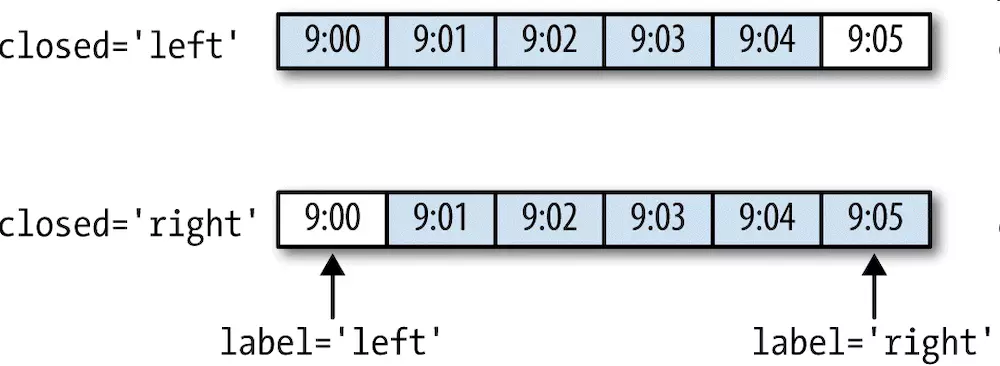

通过传递参数loffset，可以实现将结果索引移动一定的数量。在上个例子中，可以从右边减去1秒，以使其更清楚地表明时间戳所指的间隔：

In [809]:
ts.resample('5min', closed='right', label='right', loffset='-1s').sum()

1999-12-31 23:59:59     0
2000-01-01 00:04:59    15
2000-01-01 00:09:59    40
2000-01-01 00:14:59    11
Freq: 5T, dtype: int32

>也可以通过在结果上调用shift方法来完成loffset的效果

#### 开端-峰值-谷值-结束（OHLC）重新采样

在金融领域中，一种流行的时间序列局和方法是为每一个箱体计算四个值：开始值、结束值、最大值和最小值。通过使用ohlc聚合函数，可以获得一个包含这四种聚合列的DataFrame：
+ 整个过程很高效，一次扫描就可以计算出结果

In [810]:
ts.resample('5min').ohlc()

,open,high,low,close
2000-01-01 00:00:00,0,4,0,4
2000-01-01 00:05:00,5,9,5,9
2000-01-01 00:10:00,10,11,10,11


### 向上采样与插值

从低频率到高频率，并不需要=任何聚合。载入带有每周数据的DataFrame：

In [811]:
frame = pd.DataFrame(np.random.randn(2,4),index=pd.date_range('1/1/2000', periods=2,freq='W-WED'),
                     columns=['Colorado','Texas','New York','Ohio'])
frame

,Colorado,Texas,New York,Ohio
2000-01-05,1.154372,-0.273485,-0.499080,0.700336
2000-01-12,-2.608761,-1.747072,-1.006221,-0.671802


如果对这些数据使用聚合函数，则每一组只有一个值，并且会在间隙中产生缺失值。下面用asfreq方法在不聚合的情况下转换到高频率：

In [812]:
df_daily = frame.resample('D').asfreq()
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,1.154372,-0.273485,-0.499080,0.700336
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-2.608761,-1.747072,-1.006221,-0.671802


假设想在非星期三的日期上向前填充每周数值，resample有与fillna和reindex一样的填充或插值方法：
+ ffill、bfill、nearest

In [813]:
frame.resample('D').ffill()

,Colorado,Texas,New York,Ohio
2000-01-05,1.154372,-0.273485,-0.499080,0.700336
2000-01-06,1.154372,-0.273485,-0.499080,0.700336
2000-01-07,1.154372,-0.273485,-0.499080,0.700336
2000-01-08,1.154372,-0.273485,-0.499080,0.700336
2000-01-09,1.154372,-0.273485,-0.499080,0.700336
2000-01-10,1.154372,-0.273485,-0.499080,0.700336
2000-01-11,1.154372,-0.273485,-0.499080,0.700336
2000-01-12,-2.608761,-1.747072,-1.006221,-0.671802


可以选择仅向前填充一定数量的周期，以限制使用观测值的时距：

In [814]:
frame.resample('D').ffill(limit=2)

,Colorado,Texas,New York,Ohio
2000-01-05,1.154372,-0.273485,-0.499080,0.700336
2000-01-06,1.154372,-0.273485,-0.499080,0.700336
2000-01-07,1.154372,-0.273485,-0.499080,0.700336
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-2.608761,-1.747072,-1.006221,-0.671802


新的日期索引没必要与原来的日期索引重叠：

In [815]:
frame.resample('W-THU').ffill()

,Colorado,Texas,New York,Ohio
2000-01-06,1.154372,-0.273485,-0.499080,0.700336
2000-01-13,-2.608761,-1.747072,-1.006221,-0.671802


### 使用周期进行重采样

对于以周期为索引的数据进行采样与对以时间戳为索引的情况类似：

In [816]:
frame = pd.DataFrame(np.random.randn(24,4),index=pd.period_range('1-2000','12-2001',freq='M'),
                     columns=['Colorado','Texas','New York','Ohio'])
frame[:5]

,Colorado,Texas,New York,Ohio
2000-01,0.591468,-0.287192,-0.698969,0.285388
2000-02,-0.713653,1.995015,1.076020,0.022204
2000-03,0.762232,-1.636593,1.149517,-0.628331
2000-04,-0.740005,-0.377007,0.936592,-0.323634
2000-05,-0.197729,-1.120924,1.456300,-0.254148


In [817]:
annual_frame = frame.resample('A-DEC').mean()
annual_frame

,Colorado,Texas,New York,Ohio
2000,0.223203,-0.476552,0.167989,-0.230237
2001,0.452710,0.346139,0.045083,0.104365


向上采样更为细致，必须在重新采样前决定新频率中在时间段的哪一端放置数值，就像asfreq方法一样。convention参数默认值是'start'，但也可以是'end'：

In [818]:
annual_frame.resample('Q-DEC').ffill()
#Q-DEC表示每季度，年末在12月

,Colorado,Texas,New York,Ohio
2000Q1,0.223203,-0.476552,0.167989,-0.230237
2000Q2,0.223203,-0.476552,0.167989,-0.230237
2000Q3,0.223203,-0.476552,0.167989,-0.230237
2000Q4,0.223203,-0.476552,0.167989,-0.230237
2001Q1,0.452710,0.346139,0.045083,0.104365
2001Q2,0.452710,0.346139,0.045083,0.104365
2001Q3,0.452710,0.346139,0.045083,0.104365
2001Q4,0.452710,0.346139,0.045083,0.104365


In [819]:
annual_frame.resample('Q-DEC', convention='end').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,0.223203,-0.476552,0.167989,-0.230237
2001Q1,0.223203,-0.476552,0.167989,-0.230237
2001Q2,0.223203,-0.476552,0.167989,-0.230237
2001Q3,0.223203,-0.476552,0.167989,-0.230237
2001Q4,0.452710,0.346139,0.045083,0.104365


由于周期涉及时间范围，向上采样和向下采样更为严格：
+ 在向下采样中，目标频率必须是原频率的子周期
+ 在向上采样中，目标频率必须是原频率的父周期

如果不满足这些规则，将会引起异常。例如，根据Q-MAR定义的周期将只和A-MAR、A-JUN、A-SEP和A-DEC保持一致：

In [820]:
annual_frame.resample('Q-MAR').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,0.223203,-0.476552,0.167989,-0.230237
2001Q1,0.223203,-0.476552,0.167989,-0.230237
2001Q2,0.223203,-0.476552,0.167989,-0.230237
2001Q3,0.223203,-0.476552,0.167989,-0.230237
2001Q4,0.452710,0.346139,0.045083,0.104365
2002Q1,0.452710,0.346139,0.045083,0.104365
2002Q2,0.452710,0.346139,0.045083,0.104365
2002Q3,0.452710,0.346139,0.045083,0.104365


## 移动窗口函数

统计函数和其他依靠移动窗口或指数衰减而运行的函数是用于时间序列的数组变换的一个重要类别。这些函数可以平滑带有噪音或粗糙的数据。这里，将它们称为移动窗口函数（moving window function），尽管它还包括那些没有固定长度的窗口函数（如指数加权移动平均）与其他统计函数一样，移动窗口函数也会自动排除缺失值。

在升入了解之前，可以先载入一些时间序列数据并按照工作日频率进行重新采样。

In [821]:
close_px_all = pd.read_csv('C:/Users/lenovo/data_of_python/examples/stock_px.csv',parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL','MSFT','XOM']]
close_px = close_px.resample('B').ffill()

rolling算子，它的行为与resample和groupby类似。rolling可以在Series或DataFrame上通过一个window（以一个区间的数字来表示，参见下图）进行调用。

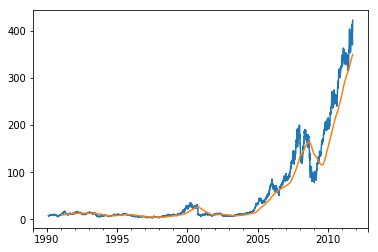

In [822]:
close_px.AAPL.plot()
close_px.AAPL.rolling(250).mean().plot()

表达式rolling(250)与groupby的行为类似，但是他创建的对象是根据250日滑动窗口分组的而不是直接分组的.因此这里获得了苹果公司股票价格的250日移动窗口平均值。

默认情况下，rolling函数要求窗口中的所有的值都必须是非NA值。存在缺失值会使的上述操作发生改变，尤其是，在时间序列的起始位置处拥有的数据少于窗口周期的时间范围这种情况：

In [823]:
appl_std250 = close_px.AAPL.rolling(250,min_periods=10).std()
appl_std250[5:12]

1990-02-08         NaN
1990-02-09         NaN
1990-02-12         NaN
1990-02-13         NaN
1990-02-14    0.148189
1990-02-15    0.141003
1990-02-16    0.135454
Freq: B, Name: AAPL, dtype: float64

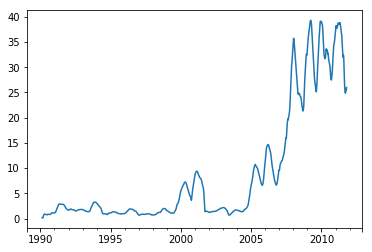

In [824]:
appl_std250.plot()

为了计算扩展窗口均值，使用expanding算子，而不是rolling算子。扩展均值从时间序列的起始位置开始时间窗口，并增加窗口的大小，直到它涵盖整个序列。apple_std250的扩展均值窗口如下：
>rolling：周期不变或着说是观测数量不变  
>expanding：周期在变大或者说观测数量在增加

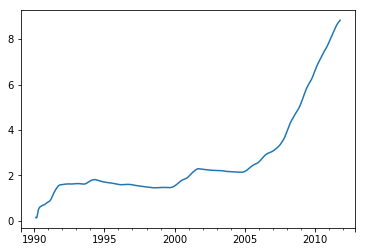

In [825]:
expanding_mean = appl_std250.expanding().mean()
expanding_mean.plot()

在DataFrame上调用一个移动窗口函数会将变换应用到每一列上：

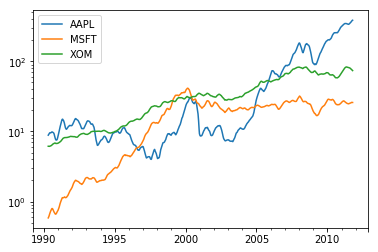

In [826]:
close_px.rolling(60).mean().plot(logy=True)

rolling函数也接收表示固定大小的时间偏置字符串，而不只是一个周期的集合数字。使用时间偏置字符串对不规则时间序列非常有用。例如，可以向下面这样计算20天的滚动平均值：

In [829]:
close_px.rolling('20D').mean()

,AAPL,MSFT,XOM
1990-02-01,7.860000,0.510000,6.120000
1990-02-02,7.930000,0.510000,6.180000
1990-02-05,8.013333,0.510000,6.203333
1990-02-06,8.040000,0.510000,6.210000
1990-02-07,7.986000,0.510000,6.234000
1990-02-08,7.940000,0.510000,6.253333
1990-02-09,7.948571,0.511429,6.270000
1990-02-12,7.947500,0.512500,6.263750
1990-02-13,7.960000,0.513333,6.260000
1990-02-14,7.964000,0.514000,6.254000


### 指数加权函数

指定一个常数衰减因子一项更多近期观测值提供更多权重，可以替代使用具有相等加权观察值的静态窗口尺寸的方法。有多种方式可以指定衰减因子。其中一种流行的的方式式使用一个span（跨度），这使得结果等同于窗口大小等于跨度的简单移动窗口函数。

由于指数加权统计值给更近期的观测值以更多的权重，与等权重的版本相比，它对变化“适应”的更快。

pandas拥有ewm算子，同rolling、expanding算子一起使用。下面，将苹果公司股票价格的60日均线与span=60的EW移动平均线进行比较：

+ EWM:  
    是以指数式递减加权的移动平均。各数值的加权影响力随时间而指数式递减，越近期的数据加权影响力越重，但较旧的数据也给予一定的加权值。加权的程度以常数α决定，α数值介乎0至1。

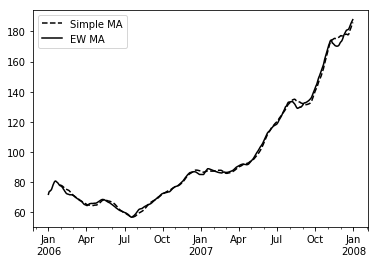

In [839]:
appl_px = close_px.AAPL['2006':'2007']
ma60 = appl_px.rolling(30, min_periods=20).mean()
ewma60 = appl_px.ewm(span=30).mean()
ma60.plot(style='k--', label='Simple MA')
ewma60.plot(style='k-', label='EW MA')
plt.legend()

### 二元移动窗口函数

有些统计运算（如相关系数和协方差）需要在两个时间序列上执行。例如，金融分析师常常对某只股票对某个参考指数（如标准普尔500指数）的相关系数感兴趣。为了来了解这个功能，我们先计算我们感兴趣的时间序列的百分数变化：
+ pct_change()返回当前元素与先前元素的百分比变化:$\frac{a_{n+1}-a_n}{a_{n+1}}$

In [840]:
spx_px = close_px_all['SPX']
spx_rets = spx_px.pct_change()
returns = close_px.pct_change()

在调用rolling后，corr聚合函数可以根据spx_rets计算滚动相关性：

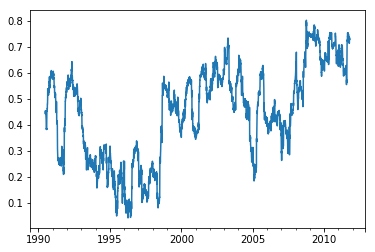

In [850]:
corr = returns.AAPL.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

假设你想要一次性计算多只股票与标准普尔500指数的相关系数。虽然编写一个循环并新建一个DataFrame很简单，但是也是冗余的。其实，传递一个Series或DataFrame，像rolling_corr这样的函数将会计算Series与DataFrame中每一列的相关性“

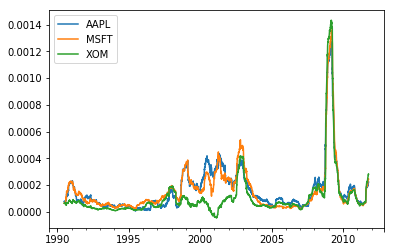

In [855]:
corr = returns.rolling(125, min_periods=100).cov(spx_rets)
corr.plot()

### 用户自定义的移动窗口函数

在rolling算子及其相关的其他算子上应用apply方法就可以实现在移动窗口中应用自定义的数组函数 的功能，唯一的要求是该函数从每个数组中产生一个单值（缩聚）。例如：

In [857]:
from scipy.stats import percentileofscore

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


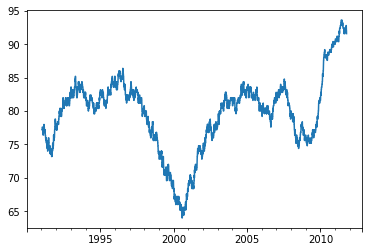

In [859]:
score_at_2percent = lambda x: percentileofscore(x, 0.02)
result = returns.AAPL.rolling(250).apply(score_at_2percent)
result.plot()